In [1]:
import math
from collections import namedtuple
import os
import re
import datetime as dt
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pprint import pprint

%matplotlib inline

In [2]:
dupes = np.array([1,3,3,5,6,7,7,8,10])
dupes_, dupes_inv, index = np.unique(dupes, return_inverse=True, return_index=True)

In [3]:
from collections import Counter

In [4]:
print(dupes_)
print(dupes_inv)
print(index)

print([item for item, count in Counter(dupes).items() if count > 1])


[ 1  3  5  6  7  8 10]
[0 1 3 4 5 7 8]
[0 1 1 2 3 4 4 5 6]
[3, 7]


In [5]:
print(type(2.5))

<class 'float'>


Define some helper methods and data structures

In [6]:
GeoExtent = namedtuple('GeoExtent', ['x_min', 'y_max', 'x_max', 'y_min'])
GeoAffine = namedtuple('GeoAffine', ['ul_x', 'x_res', 'rot_1', 'ul_y', 'rot_2', 'y_res'])
GeoCoordinate = namedtuple('GeoCoordinate', ['x', 'y'])
RowColumn = namedtuple('RowColumn', ['row', 'column'])
RowColumnExtent = namedtuple('RowColumnExtent', ['start_row', 'start_col', 'end_row', 'end_col'])

In [7]:
def geospatial_hv(h, v, loc):
    """
    Geospatial extent and 30m affine for a given ARD grid location.
    """
    xmin = loc.x_min + h * 5000 * 30
    xmax = loc.x_min + h * 5000 * 30 + 5000 * 30
    ymax = loc.y_max - v * 5000 * 30
    ymin = loc.y_max - v * 5000 * 30 - 5000 * 30

    return (GeoExtent(x_min=xmin, x_max=xmax, y_max=ymax, y_min=ymin),
            GeoAffine(ul_x=xmin, x_res=30, rot_1=0, ul_y=ymax, rot_2=0, y_res=-30))

In [8]:
def geo_to_rowcol(affine, coord):
    """
    Transform geo-coordinate to row/col given a reference affine.
    
    Yline = (Ygeo - GT(3) - Xpixel*GT(4)) / GT(5)
    Xpixel = (Xgeo - GT(0) - Yline*GT(2)) / GT(1)
    """
    row = (coord.y - affine.ul_y - affine.ul_x * affine.rot_2) / affine.y_res
    col = (coord.x - affine.ul_x - affine.ul_y * affine.rot_1) / affine.x_res

    return RowColumn(row=int(row),
                     column=int(col))

In [9]:
def rowcol_to_geo(affine, rowcol):
    """
    Transform a row/col into a geospatial coordinate given reference affine.
    
    Xgeo = GT(0) + Xpixel*GT(1) + Yline*GT(2)
    Ygeo = GT(3) + Xpixel*GT(4) + Yline*GT(5)
    """
    x = affine.ul_x + rowcol.column * affine.x_res + rowcol.row * affine.rot_1
    y = affine.ul_y + rowcol.column * affine.rot_2 + rowcol.row * affine.y_res

    return GeoCoordinate(x=x, y=y)

In [10]:
def load_cache(file):
    """
    Load the cache file and split the data into the image IDs and values
    """
    data = np.load(file)
    return data['Y'], data['image_IDs']

In [11]:
def find_file(file_ls, string):
    """
    Return the first str in a list of strings that contains string.
    """
    gen = filter(lambda x: string in x, file_ls)
    return next(gen, None)

In [12]:
def imageid_date(image_ids):
    """
    Extract the ordinal day from the ARD image name.
    """
    return np.array([dt.datetime.strptime(d[15:23], '%Y%m%d').toordinal()
                     for d in image_ids])

In [13]:
def mask_daterange(dates):
    """
    Create a mask for values outside of the global BEGIN_DATE and END_DATE.
    """
    # mask = np.zeros_like(dates, dtype=bool)
    
    mask = np.logical_and(dates >= BEGIN_DATE.toordinal(), dates <= END_DATE.toordinal())
    
    # mask[(dates >= BEGIN_DATE.toordinal()) & (dates <= END_DATE.toordinal())] = 1

    return mask

In [14]:
def mask_daterange_edit(dates):
    """
    Create a mask for values outside of the global BEGIN_DATE and END_DATE.
    Create a similar mask for values inside of these global values.
    """
    mask_in = np.zeros_like(dates, dtype=bool)
    mask_out = np.copy(mask_in)
    
    mask_in = np.logical_and(dates >= BEGIN_DATE.toordinal(), dates <= END_DATE.toordinal())
    
    # mask_in[dates >= BEGIN_DATE.toordinal() & (dates <= END_DATE.toordinal())] = 1
    
    mask_out = np.logical_or(dates < BEGIN_DATE.toordinal(), dates > END_DATE.toordinal())
    
    # mask_out[(dates < BEGIN_DATE.toordinal()) | (dates > END_DATE.toordinal())] = 1

    return mask_in, mask_out

In [15]:
def find_chipcurve(results_chip, coord):
    """
    Find the results for the specified coordinate.
    """
    with open(results_chip, 'r') as f:
        results = json.load(f)
    
    gen = filter(lambda x: coord.x == x['x'] and coord.y == x['y'], results)
    
    return next(gen, None)

In [16]:
def extract_cachepoint(coord):
    """
    Extract the spectral values from the cache file.
    """

    rowcol = geo_to_rowcol(PIXEL_AFFINE, coord)
    
    data, image_ids = load_cache(find_file(CACHE_INV, 'r{}'.format(rowcol.row)))
    
    dates = imageid_date(image_ids)
           
    return image_ids, data[:, :, rowcol.column], dates
   

In [17]:
def extract_jsoncurve(coord):
    """
    Extract the pyccd information from the json file representing a chip of results.
    """
    pixel_rowcol = geo_to_rowcol(PIXEL_AFFINE, coord)
    pixel_coord = rowcol_to_geo(PIXEL_AFFINE, pixel_rowcol)
    
    chip_rowcol = geo_to_rowcol(CHIP_AFFINE, coord)
    chip_coord = rowcol_to_geo(CHIP_AFFINE, chip_rowcol)
    
    file = find_file(JSON_INV, 'H{:02d}V{:02d}_{}_{}.json'.format(H, V, chip_coord.x, chip_coord.y))
    result = find_chipcurve(file, pixel_coord)
    
    if result.get('result_ok') is True:
        return json.loads(result['result'])

In [18]:
def predicts(days, coef, intercept):
    return (intercept + coef[0] * days +
            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))

In [19]:
def arcpaste_to_coord(string):
    pieces = string.split()
    
    return GeoCoordinate(x=float(re.sub(',', '', pieces[0])),
                         y=float(re.sub(',', '', pieces[1])))

In [20]:
def test_data():


Setup file locations

In [21]:
JSON_DIR = r'D:\LCMAP\ARD_h13v05\json'
JSON_INV = [os.path.join(JSON_DIR, f) for f in os.listdir(JSON_DIR)]
CACHE_DIR = r'D:\LCMAP\ARD_h13v05\cache'
CACHE_INV = [os.path.join(CACHE_DIR, f) for f in os.listdir(CACHE_DIR)]

In [22]:
arc_paste = '-608,699.743  2,437,196.249 Meters'
coord = arcpaste_to_coord(arc_paste)

CONUS_EXTENT = GeoExtent(x_min=-2565585,
                         y_min=14805,
                         x_max=2384415,
                         y_max=3314805)

H = 13
V = 5
EXTENT, PIXEL_AFFINE = geospatial_hv(H, V, CONUS_EXTENT)
CHIP_AFFINE = GeoAffine(ul_x=PIXEL_AFFINE.ul_x, x_res=3000, rot_1=0, ul_y=PIXEL_AFFINE.ul_y, rot_2=0, y_res=-3000)



In [23]:
results = extract_jsoncurve(coord)


In [24]:
imageIDs, data, dates = extract_cachepoint(coord)

# rescale the brightness temperature to match the predicted values
temp_thermal_data = np.copy(data[6])
temp_thermal_data[ temp_thermal_data != -9999 ] = temp_thermal_data[ temp_thermal_data != -9999 ] * 10 - 27315
data[6] = np.copy(temp_thermal_data)

In [25]:
# BEGIN_DATE = dt.datetime.fromordinal(results["change_models"][0]["start_day"])
BEGIN_DATE = dt.datetime.fromordinal(dates[0])
# END_DATE = dt.datetime.fromordinal(results["change_models"][-1]["break_day"])
END_DATE = dt.datetime.fromordinal(dates[len(results["processing_mask"])])

print(BEGIN_DATE, END_DATE)

1982-11-16 00:00:00 2015-12-30 00:00:00


Setup geospatial and temporal information

In [26]:
date_mask = mask_daterange(dates=dates)


In [27]:
dates_in = dates[date_mask]
dates_out = dates[~date_mask]

print(len(dates_in))
print(len(dates_out))

2408
185


In [29]:
# Test data
if len(dates_in) == len(results["processing_mask"]):
    print("The number of observations is consistent with the length of the PyCCD internal processing mask.\n"
          "No changes to the input observations are necessary.")

if len(np.unique(dates_in)) == len(results["processing_mask"]):
    print("There is a duplicate date occurrence in observations.  Removing duplicate occurrences makes the "
          "number of observations consistent with the length of the PyCCD internal processing mask.")

    from collections import Counter

    dupes = [item for item, count in Counter(dates).items() if count > 1]

    dates, ind, counts = np.unique(dates, return_index=True, return_counts=True)

    print(f"Duplicate dates: \n\t{[dt.datetime.fromordinal(d) for d in dupes]}")

    data = data[:, ind]

    date_mask = mask_daterange(dates)

    dates_in = dates[date_mask]

    dates_out = dates[~date_mask]

There is a duplicate date occurrence in observations.  Removing duplicate occurrences makes the number of observations consistent with the length of the PyCCD internal processing mask.
Duplicate dates: 
	[datetime.datetime(2004, 12, 23, 0, 0)]


In [30]:
print(np.shape(dates))
print(np.shape(np.unique(dates)))
print(len(results["processing_mask"]))
print(len(dates_in))
print(len(np.unique(dates_in)))


(2592,)
(2592,)
2407
2407
2407


In [31]:
data_in = data[:, date_mask]
data_out = data[:, ~date_mask]

print(np.shape(data_in))
print(np.shape(data_out))


(8, 2407)
(8, 185)


In [32]:
# Make a mask based on the ARD QA band to remove fill (value 1)
qa = data[-1]
qa_mask = np.ones_like(qa, dtype=np.bool)
qa_mask[qa == 1] = False
qa_in = qa_mask[date_mask]
qa_out = qa_mask[~date_mask]

print(len(qa_mask))
print(len(qa_in))
print(len(qa_out))

2592
2407
185


In [33]:
def msavi(R, NIR):
    # Modified Soil Adjusted Vegetation Index
    
    return (2.0 * NIR + 1.0 - ((2.0 * NIR + 1.0)**2.0 - 8.0 * (NIR - R))**0.5) / 2.0

def ndvi(R, NIR):
    # Normalized Difference Vegetation Index
    
    return (NIR - R) / (NIR + R)

def evi(B, R, NIR, G=2.5, L=1.0, C1=6, C2=7.5):
    # Enhanced Vegetation Index
    
    return G * ((NIR - R) / (NIR + C1 * R - C2 * B + L))

def savi(R, NIR, L=0.5):
    # Soil Adjusted Vegetation Index
    
    return ((NIR - R) / (NIR + R + L)) * (1 + L)

def ndmi(NIR, SWIR1):
    # Normalized Difference Moisture Index
    
    return (NIR - SWIR1) / (NIR + SWIR1)

def nbr(NIR, SWIR2):
    # Normalized Burn Ratio
    
    return (NIR - SWIR2) / (NIR + SWIR2)

def nbr2(SWIR1, SWIR2):
    # Normalized Burn Ratio 2
    
    return (SWIR1 - SWIR2) / (SWIR1 + SWIR2)  
    

Result: 0
Start Date: 1984-05-12
End Date: 1986-09-07
Break Date: 1986-09-23
QA: 8
Change prob: 1
Result: 1
Start Date: 1986-12-28
End Date: 1988-07-03
Break Date: 1988-07-26
QA: 8
Change prob: 1
Result: 2
Start Date: 1988-08-11
End Date: 1992-05-02
Break Date: 1992-05-11
QA: 8
Change prob: 1
Result: 3
Start Date: 1994-03-21
End Date: 1995-07-23
Break Date: 1995-08-15
QA: 4
Change prob: 1
Result: 4
Start Date: 1995-08-15
End Date: 2000-08-20
Break Date: 2000-08-21
QA: 8
Change prob: 1
Result: 5
Start Date: 2000-10-07
End Date: 2002-07-10
Break Date: 2002-08-03
QA: 8
Change prob: 1
Result: 6
Start Date: 2004-07-14
End Date: 2006-04-16
Break Date: 2006-05-17
QA: 8
Change prob: 1
Result: 7
Start Date: 2006-05-17
End Date: 2008-07-26
Break Date: 2008-08-02
QA: 8
Change prob: 1
Result: 8
Start Date: 2008-08-02
End Date: 2015-08-23
Break Date: 2015-08-23
QA: 8
Change prob: 0


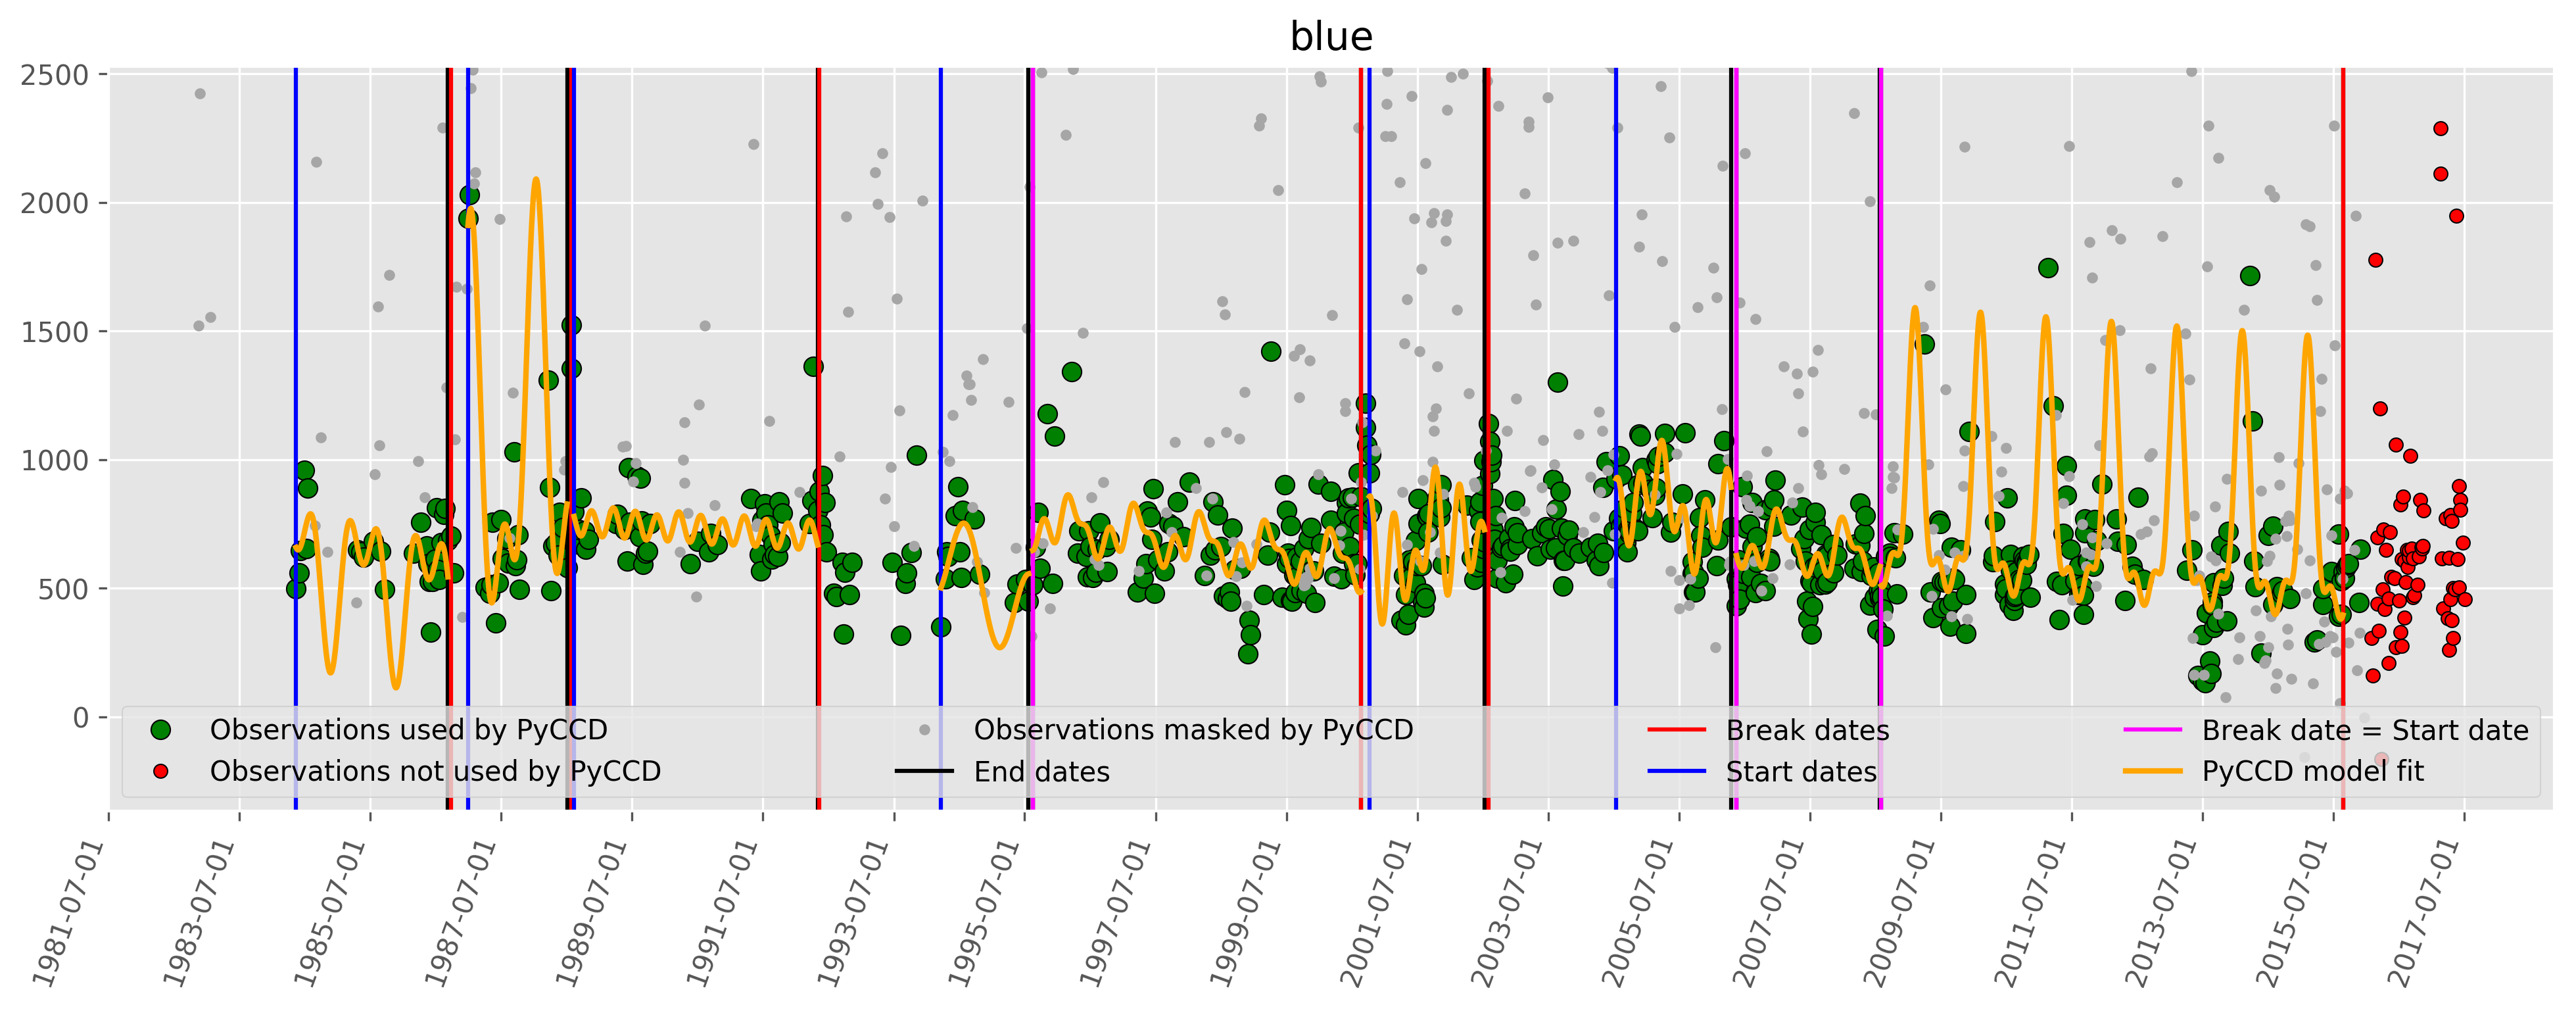

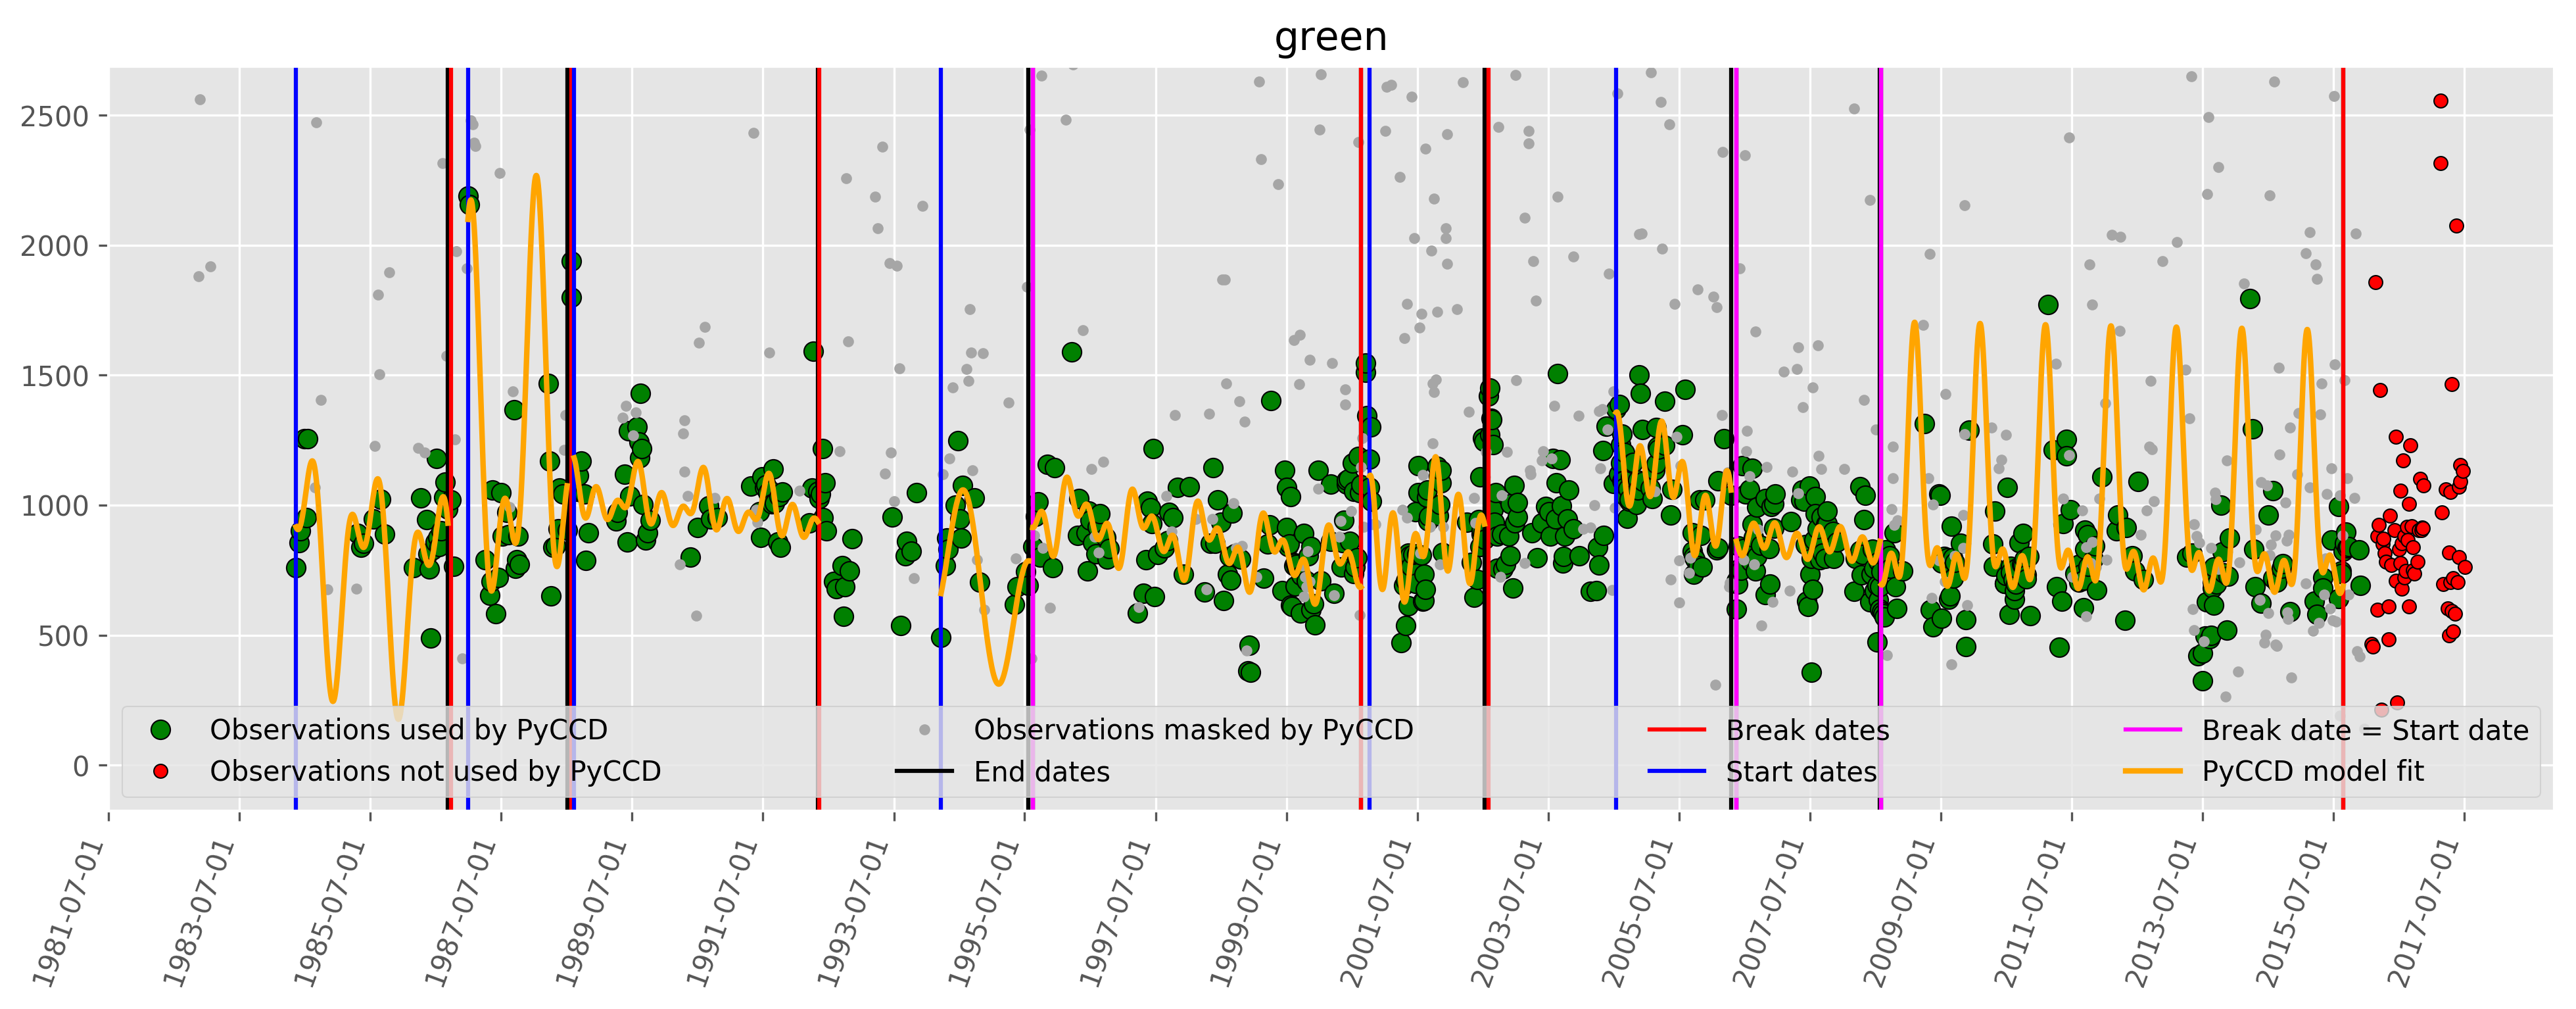

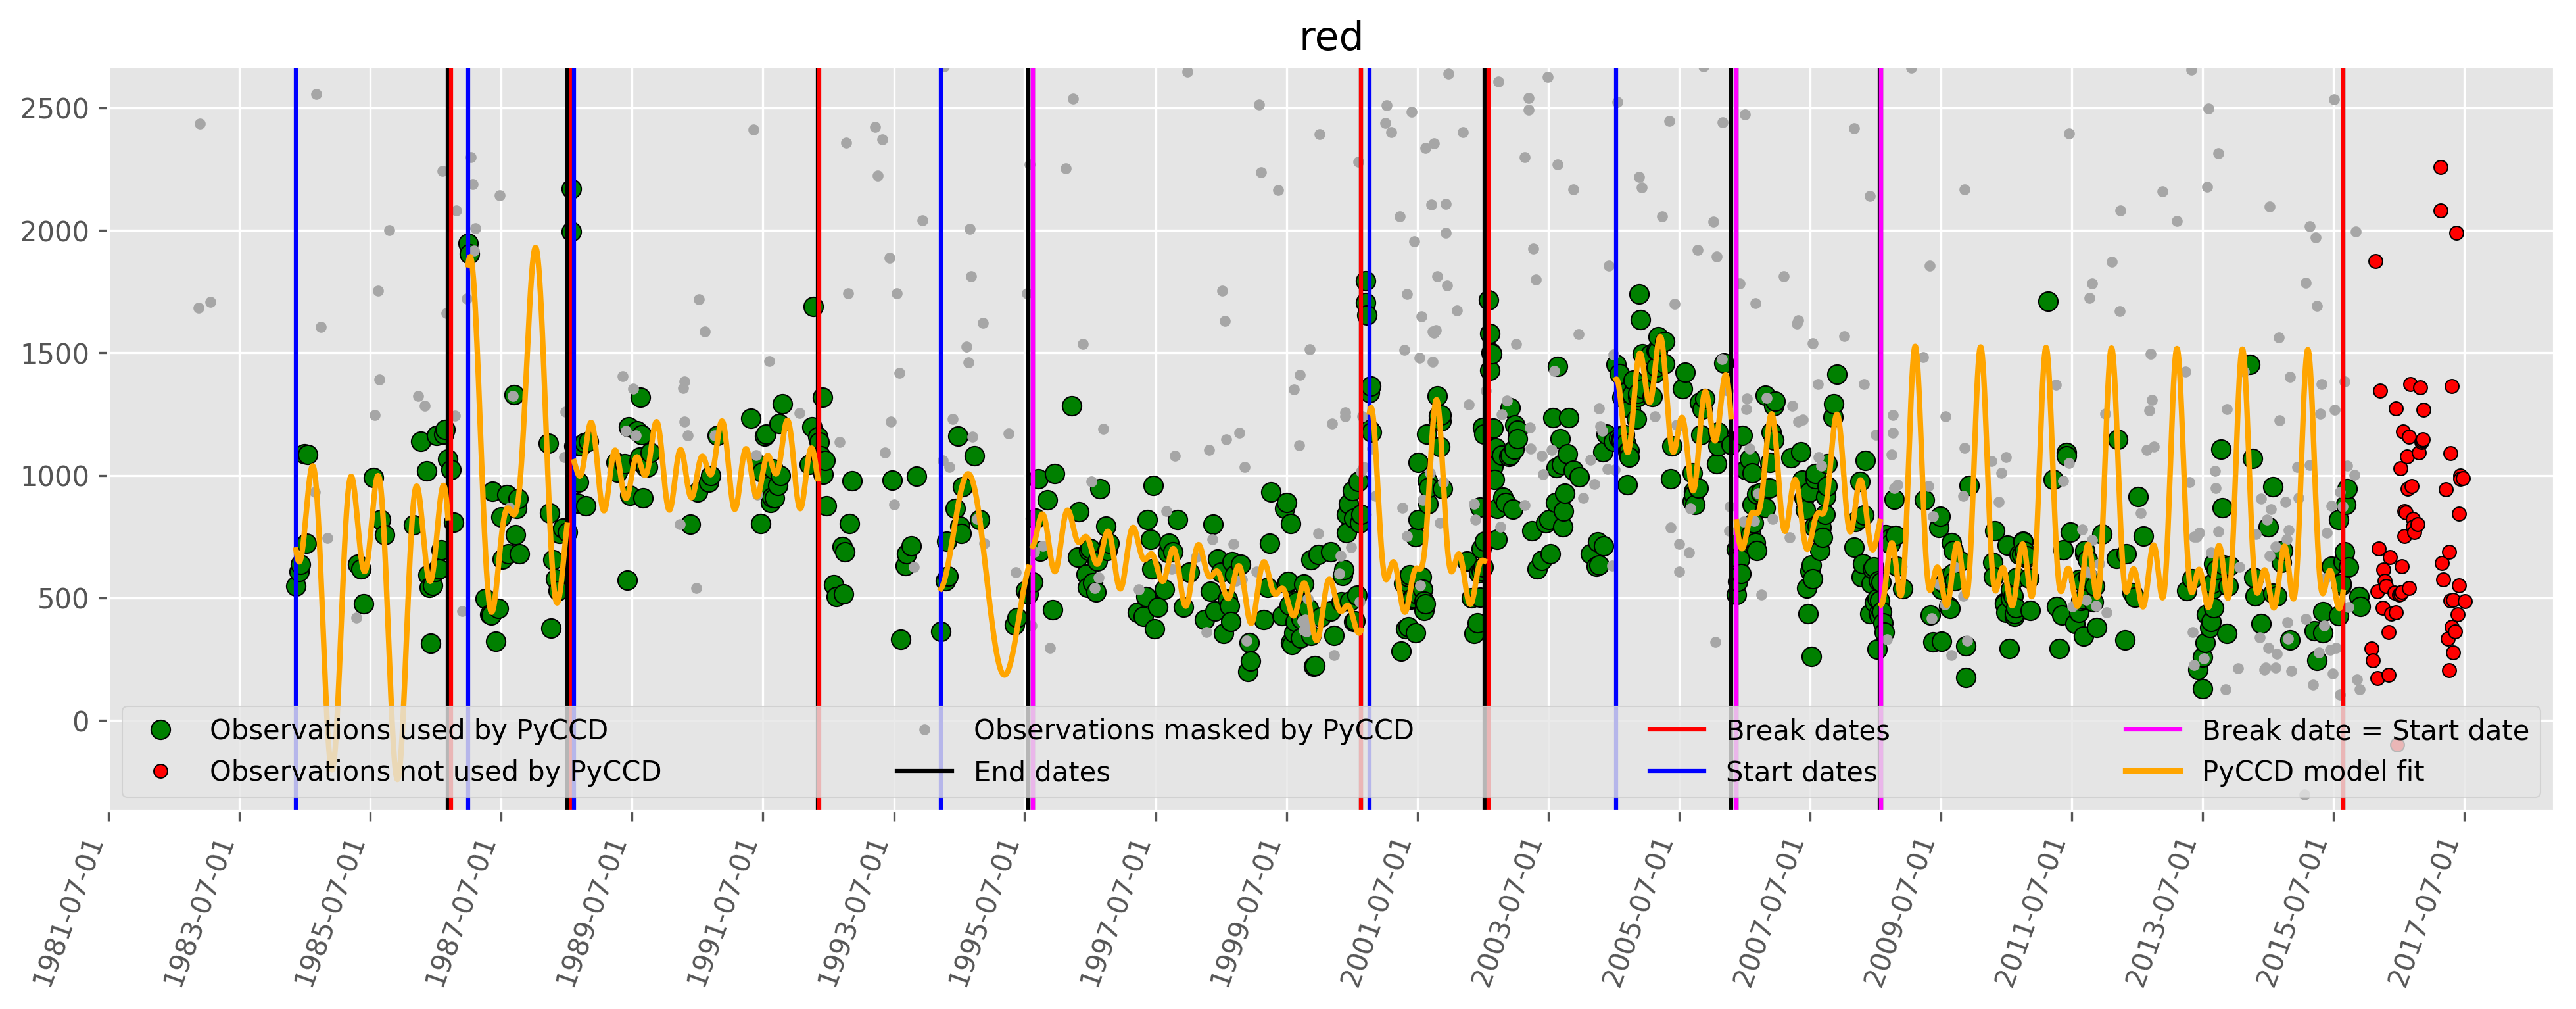

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


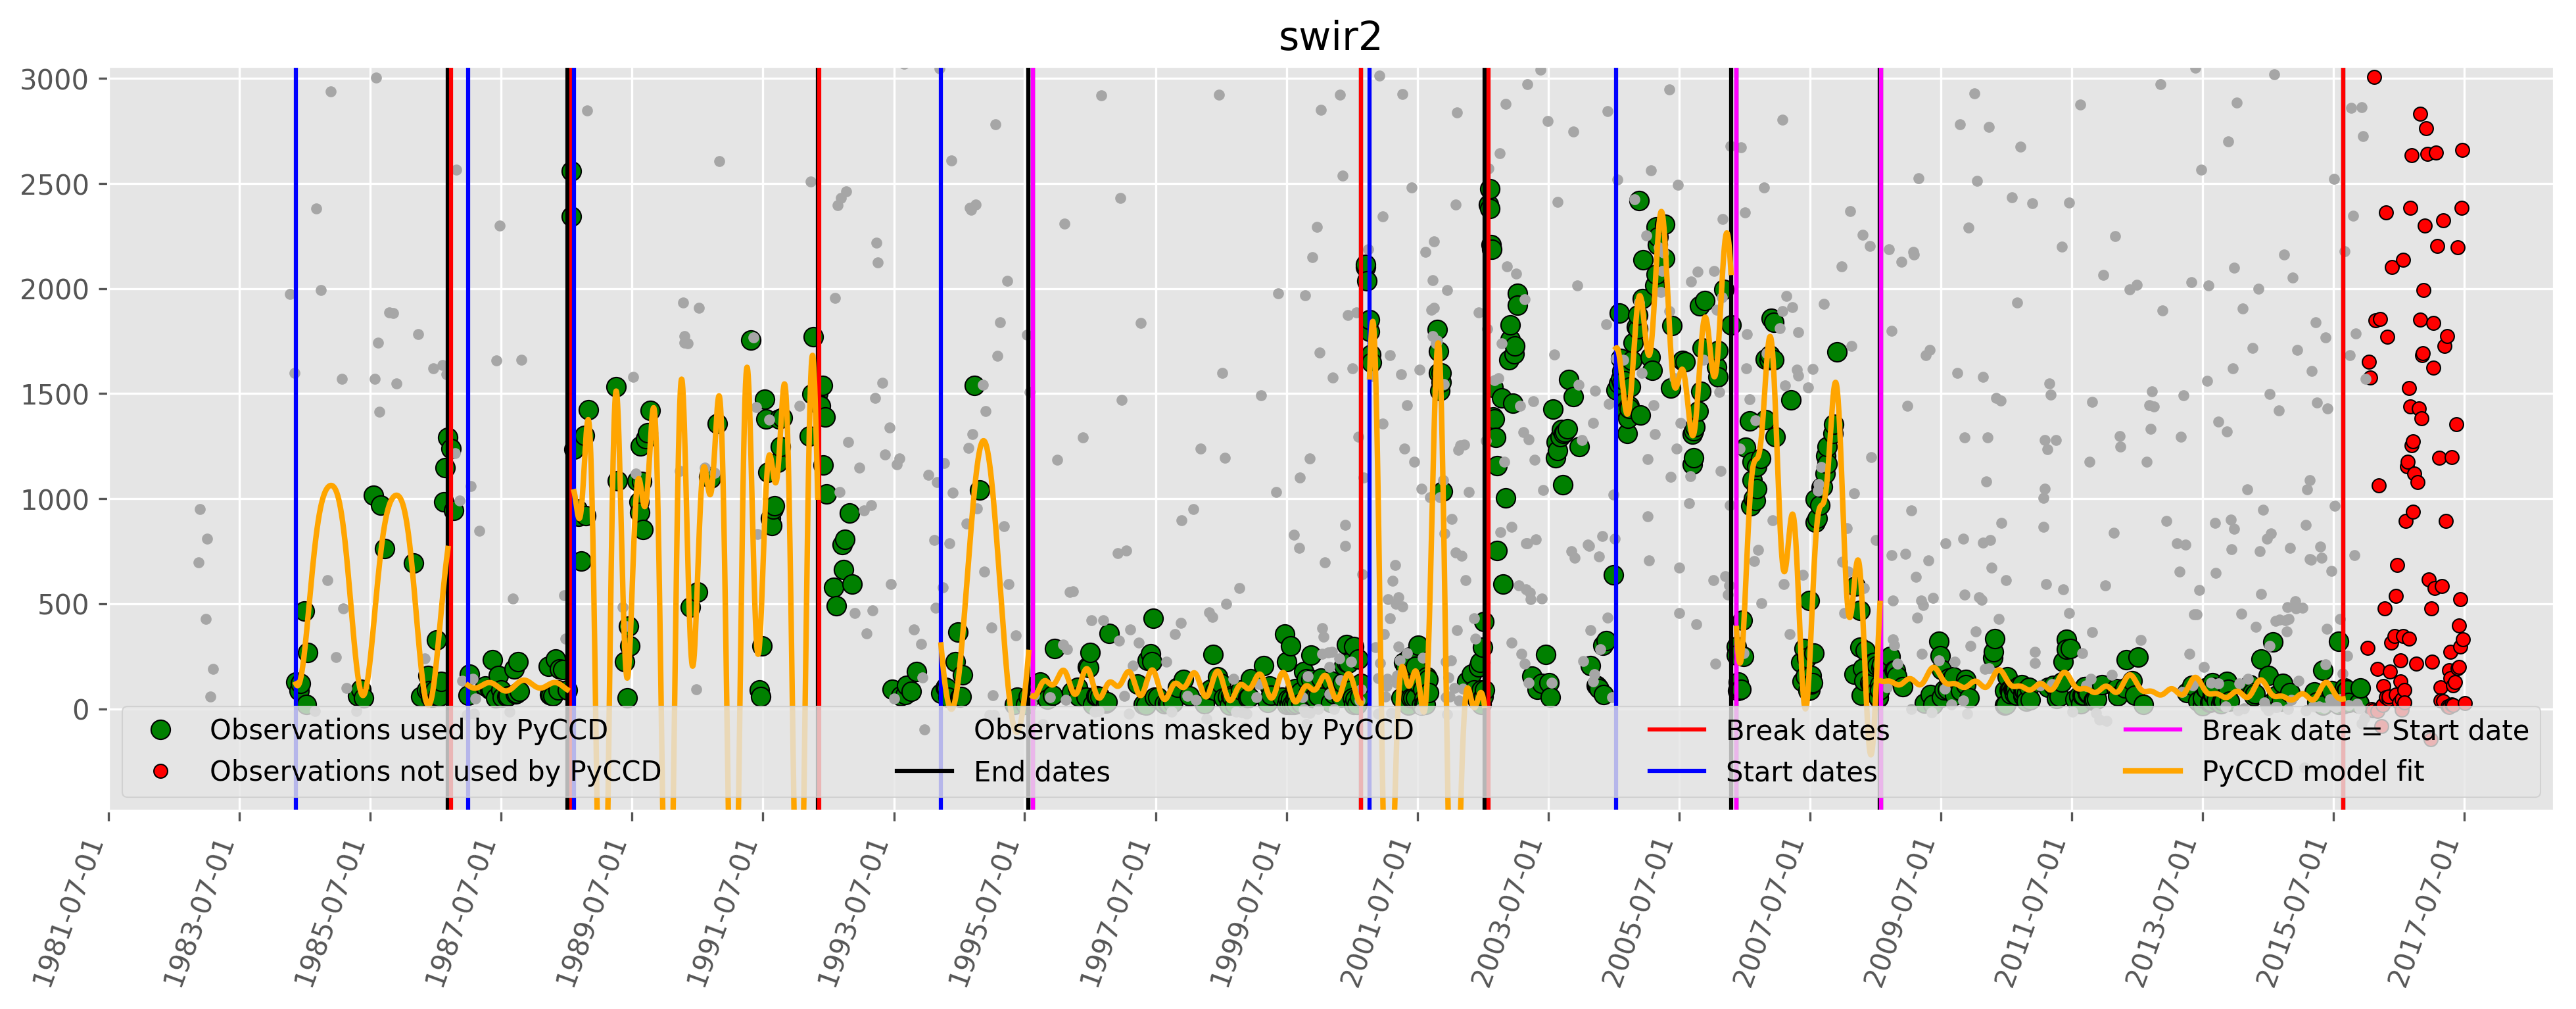

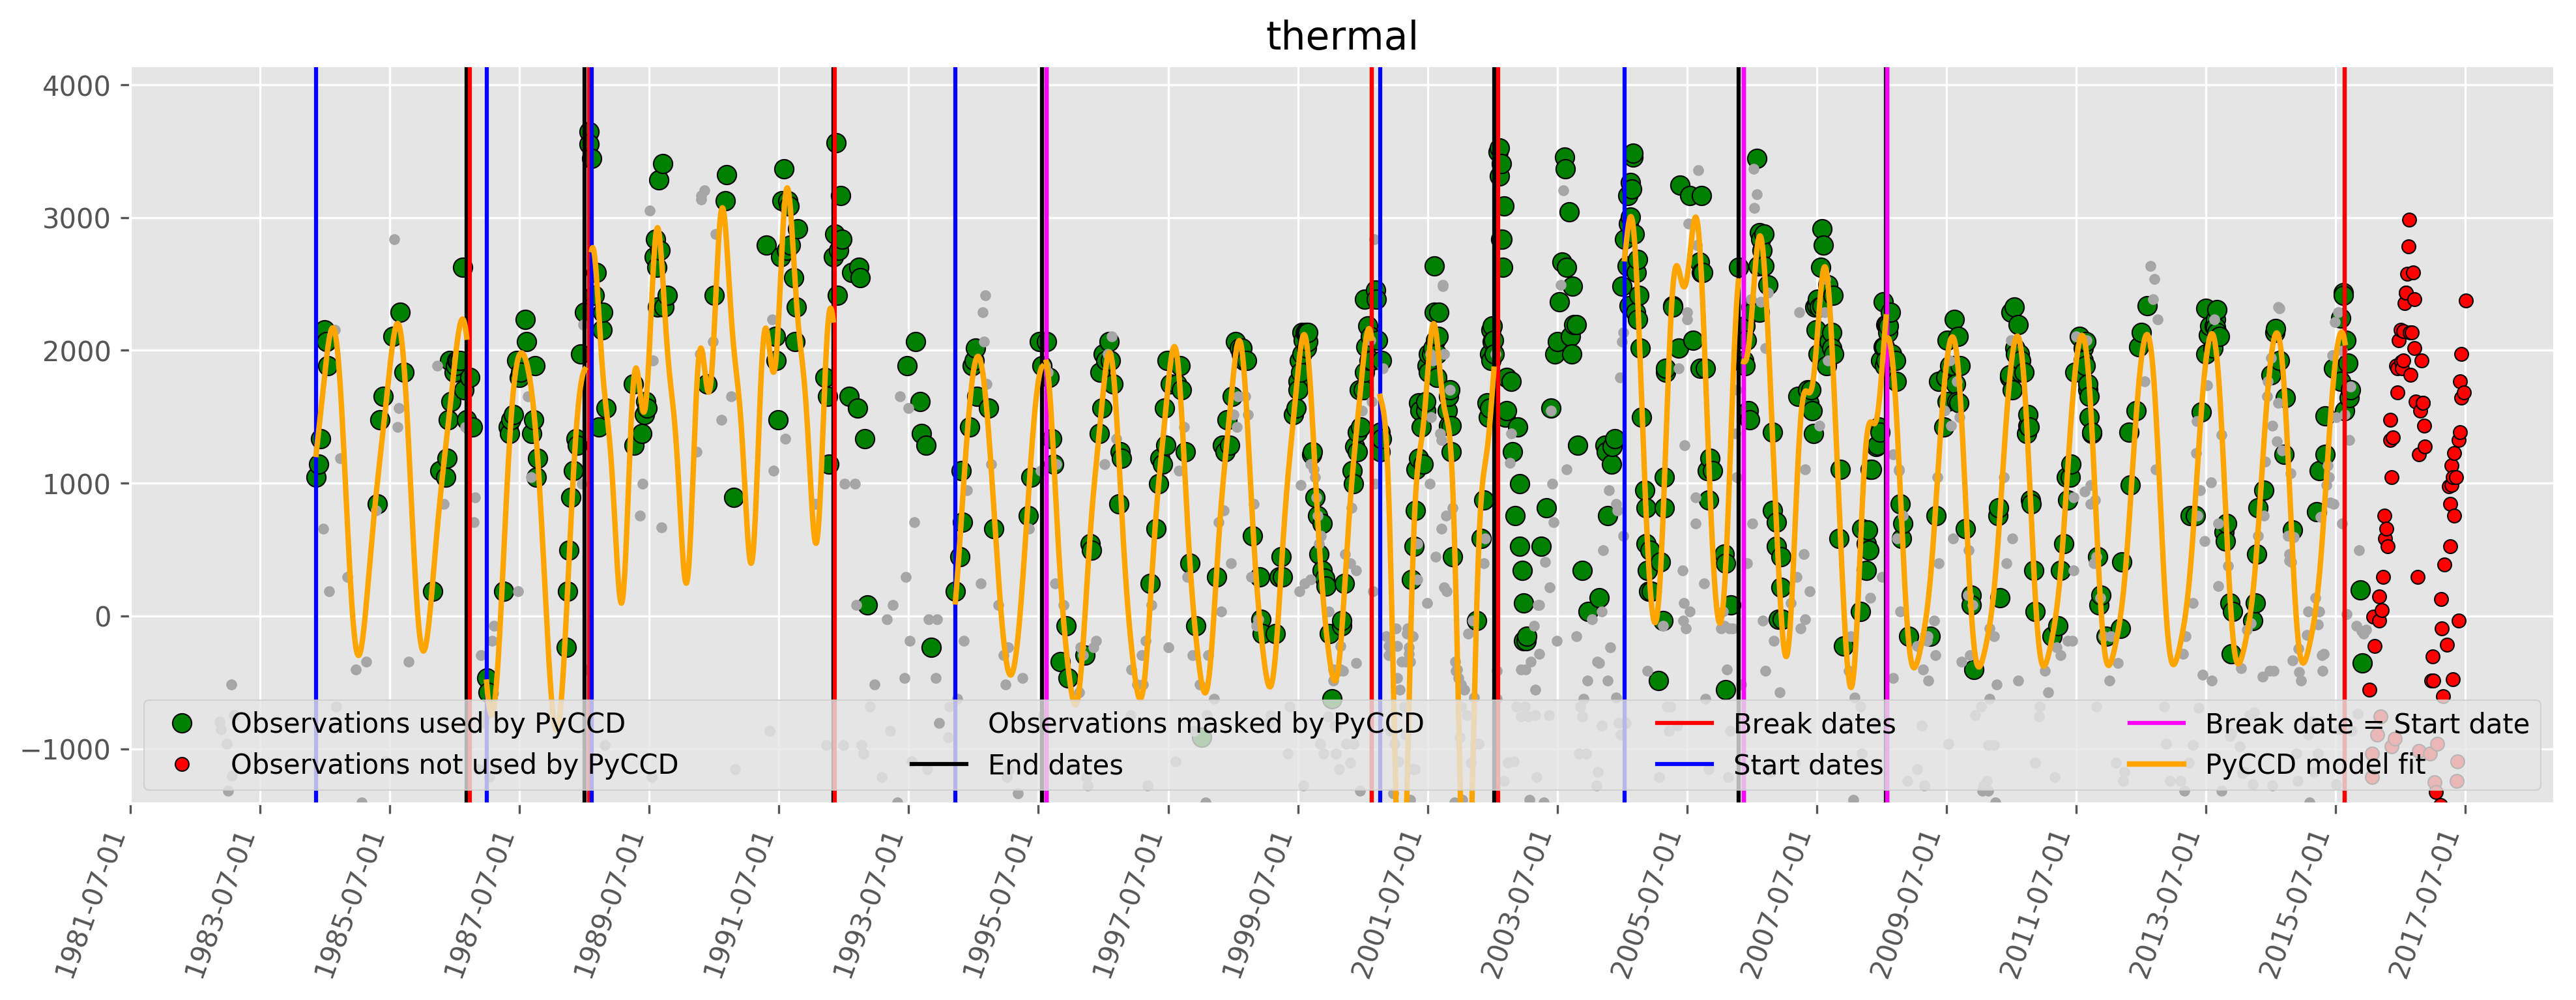

In [38]:
bands = ('blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal')
band_info = {b: {'coefs': [], 'inter': [], 'pred': []} for b in bands}

mask = np.array(results['processing_mask'], dtype=bool)

"""
print('Start Date: {0}\nEnd Date: {1}\n'.format(dt.datetime.fromordinal(dates[0]),
                                                dt.datetime.fromordinal(dates[-1])))
"""

predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []
end_dates = []

# get year values for labeling plots
year1 = str(dt.datetime.fromordinal(dates[0]))[:4]
year2 = str(dt.datetime.fromordinal(dates[-1]))[:4]
years = np.arange(int(year1), int(year2), 2)

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(dt.date.fromordinal(result['start_day'])))
    print('End Date: {}'.format(dt.date.fromordinal(result['end_day'])))
    print('Break Date: {}'.format(dt.date.fromordinal(result['break_day'])))
    print('QA: {}'.format(result['curve_qa']))
    print('Change prob: {}'.format(result['change_probability']))
    
    days = np.arange(result['start_day'], result['end_day'] + 1)
    
    break_dates.append(result['break_day'])
    start_dates.append(result['start_day'])
    end_dates.append(result['end_day'])
    
    for b in bands:
        band_info[b]['inter'] = result[b]['intercept']
        band_info[b]['coefs'] = result[b]['coefficients']
        band_info[b]['pred'] = predicts(days, result[b]['coefficients'], result[b]['intercept'])
    
        intercept = result[b]['intercept']
        coef = result[b]['coefficients']
        prediction_dates.append(days)
        predicted_values.append(predicts(days, coef, intercept))
    

plt.style.use('ggplot')


# dates_plt is the same as dates_masked
# dates_plt = dates[mask]

# ****X-Axis Ticks and Labels****
# list of years
y = [yi for yi in range(1981, 2018, 2)]

# list of datetime objects with YYYY-MM-dd pattern
t = [dt.datetime(yx, 7, 1) for yx in y]

# list of ordinal time objects
ord_time = [dt.datetime.toordinal(tx) for tx in t]

# list of datetime formatted strings
x_labels = [str(dt.datetime.fromordinal(int(L)))[:10] if L != "0.0" and L != "" else "0" for L in ord_time]

total_mask = np.logical_and(mask, qa_in)

for num, b in enumerate(bands):
    fg = plt.figure(figsize=(16,5), dpi=300)
    
    a1 = fg.add_subplot(1, 1, 1, xlim=(min(dates)-100, max(dates)+500), ylim=(min(data_in[num, total_mask]) - 500, 
                                                                                 max(data_in[num, total_mask]) + 500))
    
    
    # data_plt = data[num, mask]
    
    # Observed values in PyCCD time range
    a1.plot(dates_in[total_mask], data_in[num, total_mask], 'go', ms=7, mec='k', mew=0.5, label="Observations used by PyCCD")
    
    # Observed values outside PyCCD time range
    a1.plot(dates_out[qa_out], data_out[num][qa_out], 'ro', ms=5, mec='k', mew=0.5, label="Observations not used by PyCCD")
    
    # Observed values masked out
    a1.plot(dates_in[~mask], data_in[num, ~mask], color="0.65", marker="o", linewidth=0, ms=3, 
            label="Observations masked by PyCCD")
    
    a1.set_title(f'{b}')
    
    # plot model break and start dates
    match_dates = [b for b in break_dates for s in start_dates if b==s]
    
    for ind, e in enumerate(end_dates): 
        if ind == 0:
            a1.axvline(e, color="black", label="End dates")
        
        else:
            a1.axvline(e, color="black")
            
    
    for ind, b in enumerate(break_dates): 
        if ind == 0:
            a1.axvline(b, color='r', label="Break dates")
        
        else:
            a1.axvline(b, color='r')
        
    for ind, s in enumerate(start_dates): 
        if ind ==0:
            a1.axvline(s, color='b', label="Start dates")
        
        else:
            a1.axvline(s, color='b')
            
    for ind, m in enumerate(match_dates):
        if ind == 0:
            a1.axvline(m, color="magenta", label="Break date = Start date")
        
        else:
            a1.axvline(m, color="magenta")

    # Predicted curves
    for c in range(0 , len(results["change_models"])):
        if c == 0:
            a1.plot(prediction_dates[c * len(bands) + num], predicted_values[c * len(bands) + num],
                   "orange", linewidth=2, label="PyCCD model fit")
        
        else:
            a1.plot(prediction_dates[c * len(bands) + num], predicted_values[c * len(bands) + num],
                   "orange", linewidth=2)
        
    # Add legend
    a1.legend(mode="expand", ncol=4, loc="lower center")
    
    # Add x-ticks and x-tick_labels 
    a1.set_xticks(ord_time)

    a1.set_xticklabels(x_labels, rotation=70, horizontalalignment="right")



In [40]:
bands = ('blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal')
band_info = {b: {'coefs': [], 'inter': [], 'pred': []} for b in bands}

mask = np.array(results['processing_mask'], dtype=bool)

"""
print('Start Date: {0}\nEnd Date: {1}\n'.format(dt.datetime.fromordinal(dates[0]),
                                                dt.datetime.fromordinal(dates[-1])))
"""

predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []
end_dates = []

# get year values for labeling plots
year1 = str(dt.datetime.fromordinal(dates[0]))[:4]
year2 = str(dt.datetime.fromordinal(dates[-1]))[:4]
years = np.arange(int(year1), int(year2), 2)

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(dt.date.fromordinal(result['start_day'])))
    print('End Date: {}'.format(dt.date.fromordinal(result['end_day'])))
    print('Break Date: {}'.format(dt.date.fromordinal(result['break_day'])))
    print('QA: {}'.format(result['curve_qa']))
    print('Change prob: {}'.format(result['change_probability']))
    
    days = np.arange(result['start_day'], result['end_day'] + 1)
    
    break_dates.append(result['break_day'])
    start_dates.append(result['start_day'])
    end_dates.append(result['end_day'])
    
    for b in bands:
        band_info[b]['inter'] = result[b]['intercept']
        band_info[b]['coefs'] = result[b]['coefficients']
        band_info[b]['pred'] = predicts(days, result[b]['coefficients'], result[b]['intercept'])
    
        intercept = result[b]['intercept']
        coef = result[b]['coefficients']
        prediction_dates.append(days)
        predicted_values.append(predicts(days, coef, intercept))
    

plt.style.use('ggplot')


# dates_plt is the same as dates_masked
# dates_plt = dates[mask]

# ****X-Axis Ticks and Labels****
# list of years
y = [yi for yi in range(1981, 2018, 2)]

# list of datetime objects with YYYY-MM-dd pattern
t = [dt.datetime(yx, 7, 1) for yx in y]

# list of ordinal time objects
ord_time = [dt.datetime.toordinal(tx) for tx in t]

# list of datetime formatted strings
x_labels = [str(dt.datetime.fromordinal(int(L)))[:10] if L != "0.0" and L != "" else "0" for L in ord_time]

total_mask = np.logical_and(mask, qa_in)

fig = plt.figure(figsize=(16, 5*len(bands)), dpi=300)
for num, b in enumerate(bands):
    # fg = plt.figure(figsize=(16,5), dpi=300)
    
    a1 = fig.add_subplot(num+1, len(bands), 1, xlim=(min(dates)-100, max(dates)+500), ylim=(min(data_in[num, total_mask]) - 500, 
                                                                                 max(data_in[num, total_mask]) + 500))
    
    
    # Observed values in PyCCD time range
    a1.plot(dates_in[total_mask], data_in[num, total_mask], 'go', ms=7, mec='k', mew=0.5, label="Observations used by PyCCD")
    
    # Observed values outside PyCCD time range
    a1.plot(dates_out[qa_out], data_out[num][qa_out], 'ro', ms=5, mec='k', mew=0.5, label="Observations not used by PyCCD")
    
    # Observed values masked out
    a1.plot(dates_in[~mask], data_in[num, ~mask], color="0.65", marker="o", linewidth=0, ms=3, 
            label="Observations masked by PyCCD")
    
    a1.set_title(f'{b}')
    
    # plot model break and start dates
    match_dates = [b for b in break_dates for s in start_dates if b==s]
    
    for ind, e in enumerate(end_dates): 
        if ind == 0:
            a1.axvline(e, color="black", label="End dates")
        
        else:
            a1.axvline(e, color="black")
            
    
    for ind, b in enumerate(break_dates): 
        if ind == 0:
            a1.axvline(b, color='r', label="Break dates")
        
        else:
            a1.axvline(b, color='r')
        
    for ind, s in enumerate(start_dates): 
        if ind ==0:
            a1.axvline(s, color='b', label="Start dates")
        
        else:
            a1.axvline(s, color='b')
            
    for ind, m in enumerate(match_dates):
        if ind == 0:
            a1.axvline(m, color="magenta", label="Break date = Start date")
        
        else:
            a1.axvline(m, color="magenta")

    # Predicted curves
    for c in range(0 , len(results["change_models"])):
        if c == 0:
            a1.plot(prediction_dates[c * len(bands) + num], predicted_values[c * len(bands) + num],
                   "orange", linewidth=2, label="PyCCD model fit")
        
        else:
            a1.plot(prediction_dates[c * len(bands) + num], predicted_values[c * len(bands) + num],
                   "orange", linewidth=2)
        
    # Add legend
    a1.legend(mode="expand", ncol=4, loc="lower center")
    
    # Add x-ticks and x-tick_labels 
    a1.set_xticks(ord_time)

    a1.set_xticklabels(x_labels, rotation=70, horizontalalignment="right")



Result: 0
Start Date: 1984-05-12
End Date: 1986-09-07
Break Date: 1986-09-23
QA: 8
Change prob: 1
Result: 1
Start Date: 1986-12-28
End Date: 1988-07-03
Break Date: 1988-07-26
QA: 8
Change prob: 1
Result: 2
Start Date: 1988-08-11
End Date: 1992-05-02
Break Date: 1992-05-11
QA: 8
Change prob: 1
Result: 3
Start Date: 1994-03-21
End Date: 1995-07-23
Break Date: 1995-08-15
QA: 4
Change prob: 1
Result: 4
Start Date: 1995-08-15
End Date: 2000-08-20
Break Date: 2000-08-21
QA: 8
Change prob: 1
Result: 5
Start Date: 2000-10-07
End Date: 2002-07-10
Break Date: 2002-08-03
QA: 8
Change prob: 1
Result: 6
Start Date: 2004-07-14
End Date: 2006-04-16
Break Date: 2006-05-17
QA: 8
Change prob: 1
Result: 7
Start Date: 2006-05-17
End Date: 2008-07-26
Break Date: 2008-08-02
QA: 8
Change prob: 1
Result: 8
Start Date: 2008-08-02
End Date: 2015-08-23
Break Date: 2015-08-23
QA: 8
Change prob: 0


RuntimeError: 

In [ ]:
# plot indices
NDVI = ndvi(NIR=data[3], R=data[2])
MSAVI = msavi(NIR=data[3], R=data[2])
EVI = evi(B=data[0], NIR=data[3], R=data[2])
SAVI = savi(NIR=data[3], R=data[2])
NDMI = ndmi(NIR=data[3], SWIR1=data[4])
NBR = nbr(NIR=data[3], SWIR2=data[5])
NBR2 = nbr2(SWIR1=data[4], SWIR2=data[5])

NDVI_ = [ndvi(NIR=predicted_values[m * len(bands) + 3], R=predicted_values[m * len(bands) + 2]) 
         for m in range(len(results["change_models"]))]

MSAVI_ = [msavi(R=predicted_values[m * len(bands) + 2], NIR=predicted_values[m * len(bands) + 3]) 
          for m in range(len(results["change_models"]))]

EVI_ = [evi(B=predicted_values[m * len(bands)], NIR=predicted_values[m * len(bands) + 3], 
            R=predicted_values[m * len(bands) + 2]) for m in range(len(results["change_models"]))]

SAVI_ = [savi(NIR=predicted_values[m * len(bands) + 3], R=predicted_values[m * len(bands) + 2]) 
         for m in range(len(results["change_models"]))]

NDMI_ = [ndmi(NIR=predicted_values[m * len(bands) + 3], SWIR1=predicted_values[m * len(bands) + 4]) 
         for m in range(len(results["change_models"]))]
              
NBR_ = [nbr(NIR=predicted_values[m * len(bands) + 3], SWIR2=predicted_values[m * len(bands) + 5]) 
        for m in range(len(results["change_models"]))]

NBR2_ = [nbr2(SWIR1=predicted_values[m * len(bands) + 4], SWIR2=predicted_values[m * len(bands) + 5]) 
         for m in range(len(results["change_models"]))]


indices = {"ndvi":(NDVI, NDVI_), "msavi":(MSAVI, MSAVI_), "evi":(EVI, EVI_), "savi":(SAVI, SAVI_), 
           "ndmi":(NDMI, NDMI_), "nbr":(NBR, NBR_), "nbr2":(NBR2, NBR2_)}


In [ ]:


# ****X-Axis Ticks and Labels****

# get year values for labeling plots
year1 = str(dt.datetime.fromordinal(dates[0]))[:4]
year2 = str(dt.datetime.fromordinal(dates[-1]))[:4]
years = np.arange(int(year1), int(year2) + 2, 2)

# list of datetime objects with YYYY-MM-dd pattern
t = [dt.datetime(yx, 7, 1) for yx in years]

# list of ordinal time objects
ord_time = [dt.datetime.toordinal(tx) for tx in t]

# list of datetime formatted strings
x_labels = [str(dt.datetime.fromordinal(int(L)))[:10] if L != "0.0" and L != "" else "0" for L in ord_time]

for num, i in enumerate(indices):
    
    index_in = indices[i][0][date_mask]
    index_out = indices[i][0][~date_mask]
    
    fg = plt.figure(figsize=(16,9), dpi=300)
    a1 = fg.add_subplot(2,1,1, ylim=(min(index_in[total_mask]) - 0.1, max(index_in[total_mask]) + 0.1))

    a1.set_xticks(ord_time)
    a1.set_xticklabels(x_labels, rotation=70, horizontalalignment="right")

    # plot observed calculated index values within PyCCD date range
    a1.plot(dates_in[total_mask], index_in[total_mask], 'go', ms=7, mec='k', mew=0.5)
    
    # plot observed calculated index values masked out within PyCCD date range
    a1.plot(dates_in[~total_mask][index_in[~total_mask] != 0], index_in[~total_mask][index_in[~total_mask] != 0], color="0.65", ms=5, mec='k', mew=0.5, marker="o", linewidth=0)
    
    # plot observed calculated index values outside of PyCCD date range
    a1.plot(dates_out[qa_out], index_out[qa_out], "ro", ms=5, mec="k", mew=0.5)
    
    # Predicted curves
    for c in range(0 , len(results["change_models"])):
        a1.plot(prediction_dates[c * len(bands)], indices[i][1][c],"orange", linewidth=2)
        
        # plot model break and start dates
    match_dates = [b for b in break_dates for s in start_dates if b==s]
    for b in break_dates: a1.axvline(b, color='r')
        
    for s in start_dates: a1.axvline(s, color='b')

    for m in match_dates: a1.axvline(m, color="magenta")   
    
    a1.set_title(i)

In [ ]:
bands = ('blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal')
band_info = {b: {'coefs': [], 'inter': [], 'pred': []} for b in bands}

mask = np.array(results['processing_mask'], dtype=bool)

"""
print('Start Date: {0}\nEnd Date: {1}\n'.format(dt.datetime.fromordinal(dates[0]),
                                                dt.datetime.fromordinal(dates[-1])))
"""

predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []
end_dates = []

# get year values for labeling plots
year1 = str(dt.datetime.fromordinal(dates[0]))[:4]
year2 = str(dt.datetime.fromordinal(dates[-1]))[:4]
years = np.arange(int(year1), int(year2), 2)

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(dt.date.fromordinal(result['start_day'])))
    print('End Date: {}'.format(dt.date.fromordinal(result['end_day'])))
    print('Break Date: {}'.format(dt.date.fromordinal(result['break_day'])))
    print('QA: {}'.format(result['curve_qa']))
    print('Change prob: {}'.format(result['change_probability']))
    
    days = np.arange(result['start_day'], result['end_day'] + 1)
    
    break_dates.append(result['break_day'])
    start_dates.append(result['start_day'])
    end_dates.append(result['end_day'])
    
    for b in bands:
        band_info[b]['inter'] = result[b]['intercept']
        band_info[b]['coefs'] = result[b]['coefficients']
        band_info[b]['pred'] = predicts(days, result[b]['coefficients'], result[b]['intercept'])
    
        intercept = result[b]['intercept']
        coef = result[b]['coefficients']
        prediction_dates.append(days)
        predicted_values.append(predicts(days, coef, intercept))
    

plt.style.use('ggplot')


# dates_plt is the same as dates_masked
# dates_plt = dates[mask]

# ****X-Axis Ticks and Labels****
# list of years
y = [yi for yi in range(1981, 2018, 2)]

# list of datetime objects with YYYY-MM-dd pattern
t = [dt.datetime(yx, 7, 1) for yx in y]

# list of ordinal time objects
ord_time = [dt.datetime.toordinal(tx) for tx in t]

# list of datetime formatted strings
x_labels = [str(dt.datetime.fromordinal(int(L)))[:10] if L != "0.0" and L != "" else "0" for L in ord_time]

total_mask = np.logical_and(mask, qa_in)

for num, b in enumerate(bands):
    fg = plt.figure(figsize=(16,9), dpi=300)
    a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates)-100, max(dates)+500), ylim=(min(data_in[num, total_mask]) - 500, 
                                                                                 max(data_in[num, total_mask]) + 500))
    
    
    # data_plt = data[num, mask]
    
    # Observed values in PyCCD time range
    a1.plot(dates_in[total_mask], data_in[num, total_mask], 'go', ms=7, mec='k', mew=0.5)
    
    # Observed values outside PyCCD time range
    a1.plot(dates_out[qa_out], data_out[num][qa_out], 'ro', ms=5, mec='k', mew=0.5)
    
    # Observed values masked out
    a1.plot(dates_in[~mask], data_in[num, ~mask], color="0.65", marker="o", linewidth=0, ms=3)
    
    a1.set_title(f'{b}')
    
    # plot model break and start dates
    match_dates = [b for b in break_dates for s in start_dates if b==s]
    for b in break_dates: a1.axvline(b, color='red')
        
    for s in start_dates: a1.axvline(s, color='b')

    for e in end_dates: a1.axvline(e, color="black")
    
    for m in match_dates: a1.axvline(m, color="magenta")
        
    
                
    
    # Predicted curves
    for c in range(0 , len(results["change_models"])):
        a1.plot(prediction_dates[c * len(bands) + num], predicted_values[c * len(bands) + num],
               "orange", linewidth=2)

    # Add x-ticks and x-tick_labels 
    a1.set_xticks(ord_time)

    a1.set_xticklabels(x_labels, rotation=70, horizontalalignment="right")



In [ ]:
np.shape(data)

In [ ]:
np.shape(data[6])

In [ ]:
indices = ('ndvi', 'msavi', 'evi', 'savi', 'ndmi', 'nbr', 'nbr2')

In [ ]:
index_lookup = {"ndvi": (NDVI, NDVI_), "msavi": (MSAVI, MSAVI_),
                        "evi": (EVI, EVI_),"savi": (SAVI, SAVI_), "ndmi": (NDMI, NDMI_),
                        "nbr": (NBR, NBR_),"nbr2": (NBR2, NBR2_)}

band_lookup = {"blue" : data[0], "green" : data[1], "red" : [2], "nir" : [3], "swir-1" : [4], "swir-2" : [5], "thermal" : [6]}

all_lookup = {**index_lookup, **band_lookup}

In [ ]:
items = ["green", "purple", "red", "ndvi", "apple"]
retrieve = None

retrieve = {i : all_lookup[i] for i in items if i in all_lookup.keys()}


In [ ]:
len(retrieve)

In [ ]:
items=['all']
print(items[0])

In [ ]:
items = []
len(items)

In [ ]:
num=135
if isinstance(num, int):
    num=[num]
print([n for n in num])

In [ ]:
a=5
a = [a]